# 3 qubit logical T1 calculation

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from circuit_specific.drawing_helpers import *
from general_qec.qec_helpers import *
from general_qec.gates import *
from general_qec.errors import *
from circuit_specific.three_qubit_logical_t1 import *

# For fitting exponentials
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

# for exponential warnings
import warnings
#suppress warnings
warnings.filterwarnings('ignore')

## Contents
1. [Introduction](#introduction)
2. [Implementing the 3 qubit code with relaxation and dephasing errors](#errors)
3. [Calculating the logical T1 for the 3 qubit bit correction circuit](#t1)
4. [More realistic error implementation](#realistic)
5. [Modelling Circuit logical state failure](#failure)


## 1. Introduction  <a id='introduction'></a>

### In this file we will restrict our 3 qubit connectivity to line connected circuit and implement our T1 and T2 error model to check for our logical T1 and T2 after running our 3 qubit correction circuit with line connectivity many times. 
#### In the end we will plot our qubit population over time in our circuit. This is essentially plotting the probability that we will measure our system in a 'non-relaxed' state. Additionally, we will see how increasing the depolarization errors will effect the logical state of our system.

Recall the circuit for the 3 qubit error correction below

In [ ]:
draw_three_qubit_code()

## 2. Implementing the 3 qubit code with relaxation and dephasing errors <a id='errors'></a>

#### We will now implement the relaxation and dephasing model created in <u>05. Error Models</u>.

Since we implemented our 3 qubit code using functions, we will need to pull those in here but change them up a bit.

In [ ]:
zero = np.array([1, 0])
one = np.array([0, 1])

initial_psi = one # initialize our psi

# the parameters of our system
t1 = 200 * 10**-6
t2 = 150 * 10**-6
tg = 20 * 10**-9
# Set other errors to none
spam_prob = None
qubit_error_probs = None

# Initialize the 3 qubit logical state
initial_logical_state = np.kron(initial_psi, np.kron(zero, np.kron(zero, np.kron(zero, zero))))

# Find the density matrix of our logical system
initial_rho = np.kron(initial_logical_state, initial_logical_state[np.newaxis].conj().T)


# Apply the CNOT gates to the kronecker product of the current 3 qubit density matrix (the gates will implement t1 and t2)
rho = line_rad_CNOT(initial_rho, 0, 1, t1, t2, tg, form = 'rho') # first CNOT gate
rho = line_rad_CNOT(rho, 1, 2, t1, t2, tg, form = 'rho') # second CNOT gate

# Measure the probability of being in the correct state
zero_meas = np.kron(zero, zero[np.newaxis].conj().T)
one_meas = np.kron(one, one[np.newaxis].conj().T)
M_state = np.kron(one_meas, np.kron(one_meas, np.kron(one_meas, np.identity(2**2))))
state_prob = np.trace(np.dot(M_state.conj().T, np.dot(M_state, rho)))
print('Probability of being in the correct state when measured: ', state_prob)

Now to implement the CNOT gates to couple the syndrome ancilla with the logical qubit

In [ ]:
initial_rho = rho
# total number of qubits in our system
n = int(np.log(len(initial_rho))/np.log(2))

# Apply state prep error if spam_probs is not empty
if spam_prob != None:
    for index in range(n):
        initial_rho = spam_error(initial_rho, spam_prob, index)

# Apply CNOT gates depending on error parameters 
if ((t1!=None) and (t2!=None) and (tg!=None)) and (qubit_error_probs is not None):
    # Apply the CNOT gates needed to change the state of the syndrome ancilla 
    detection_rho = prob_line_rad_CNOT(initial_rho, 0, 3, t1, t2, tg, qubit_error_probs, form = 'rho')
    detection_rho = prob_line_rad_CNOT(detection_rho, 1, 3, t1, t2, tg, qubit_error_probs, form = 'rho')
    detection_rho = prob_line_rad_CNOT(detection_rho, 0, 4, t1, t2, tg, qubit_error_probs, form = 'rho')
    detection_rho = prob_line_rad_CNOT(detection_rho, 2, 4, t1, t2, tg, qubit_error_probs, form = 'rho')
elif ((t1!=None) and (t2!=None) and (tg!=None)) and (qubit_error_probs is None):
    # Apply the CNOT gates needed to change the state of the syndrome ancilla 
    detection_rho = line_rad_CNOT(initial_rho, 0, 3, t1, t2, tg, form = 'rho')
    detection_rho = line_rad_CNOT(detection_rho, 1, 3, t1, t2, tg, form = 'rho')
    detection_rho = line_rad_CNOT(detection_rho, 0, 4, t1, t2, tg, form = 'rho')
    detection_rho = line_rad_CNOT(detection_rho, 2, 4, t1, t2, tg, form = 'rho')
elif ((t1==None) and (t2==None) and (tg==None)) and (qubit_error_probs is not None):
    # Apply the CNOT gates needed to change the state of the syndrome ancilla 
    detection_rho = line_errored_CNOT(initial_rho, 0, 3, qubit_error_probs, form = 'rho')
    detection_rho = line_errored_CNOT(detection_rho, 1, 3, qubit_error_probs, form = 'rho')
    detection_rho = line_errored_CNOT(detection_rho, 0, 4, qubit_error_probs, form = 'rho')
    detection_rho = line_errored_CNOT(detection_rho, 2, 4, qubit_error_probs, form = 'rho')
else:
    # Apply the CNOT gates needed to change the state of the syndrome ancilla 
    gate1 = CNOT(0, 3, 5)
    gate2 = CNOT(1, 3, 5)
    gate3 = CNOT(0, 4, 5)
    gate4 = CNOT(2, 4, 5)

    detection_rho = np.dot(gate1, np.dot(initial_rho, gate1.conj().T))
    detection_rho = np.dot(gate2, np.dot(detection_rho, gate2.conj().T))
    detection_rho = np.dot(gate3, np.dot(detection_rho, gate3.conj().T))
    detection_rho = np.dot(gate4, np.dot(detection_rho, gate4.conj().T))

# Check probability of being in the correct state
state_prob = np.trace(np.dot(M_state.conj().T, np.dot(M_state, detection_rho)))
print('Probability of being in the correct state when measured: ', state_prob)

Now detect where the error occured by measuring the two syndrom ancilla

In [ ]:
# Apply state measurement error if spam_probs is not empty
if spam_prob != None:
    detection_rho = spam_error(detection_rho, spam_prob, 3) # ancilla 0
    detection_rho = spam_error(detection_rho, spam_prob, 4) # ancilla 1


# Define the measurement projection operators
zero_meas = np.kron(zero, zero[np.newaxis].conj().T)
one_meas = np.kron(one, one[np.newaxis].conj().T)
M1 = np.kron(np.identity(2**3), np.kron(zero_meas, zero_meas))
M2 = np.kron(np.identity(2**3), np.kron(zero_meas, one_meas))
M3 = np.kron(np.identity(2**3), np.kron(one_meas, zero_meas))
M4 = np.kron(np.identity(2**3), np.kron(one_meas, one_meas))

all_meas = np.array([M1, M2, M3, M4])

# find the probability to measure each case
m1_prob = np.trace(np.dot(M1.conj().T, np.dot(M1, detection_rho)))
m2_prob = np.trace(np.dot(M2.conj().T, np.dot(M2, detection_rho)))
m3_prob = np.trace(np.dot(M3.conj().T, np.dot(M3, detection_rho)))
m4_prob = np.trace(np.dot(M4.conj().T, np.dot(M4, detection_rho)))

all_probs = np.array([m1_prob, m2_prob, m3_prob, m4_prob])

# find which measurement operator is measured based on their probabilities
index = random.choices(all_probs, weights=all_probs, k=1)
index = np.where(all_probs == index)[0][0]

# apply correct measurement collapse of the density matrix
rho_prime = np.dot(all_meas[index], np.dot(detection_rho, all_meas[index].conj().T))/(all_probs[index])
# Create our new density matrix after collapsing ancilla qubits
detection_rho = rho_prime

# Initialize error index

if index == 3: # Error on qubit 0
    error_index = 0
elif index == 2: # Error on qubit 1
    error_index = 1
elif index == 1: # Error on qubit 2
    error_index = 2
elif index == 0:
    error_index = -1

# output error information
if error_index != -1:
    print('Error was measured on qubit:', error_index)
else:
    print('No error was measured.')

Now to correct for our error

In [ ]:
# apply the error correction based on the detected index
if error_index == 0: # Error on qubit 0
    correction_gate = np.kron(sigma_x, np.identity(2**4))
    corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))

    if qubit_error_probs is not None:
        corrected_rho = gate_error(corrected_rho, qubit_error_probs[0], 0, n) # gate error probability
    if ((t1!=None) and (t2!=None) and (tg!=None)):
        corrected_rho = rad_error(corrected_rho, t1, t2, tg) # apply rad error

elif error_index == 1: # Error on qubit 1
    correction_gate = np.kron(np.identity(2), np.kron(sigma_x, np.identity(2**3)))
    corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))

    if qubit_error_probs is not None:
        corrected_rho = gate_error(corrected_rho, qubit_error_probs[1], 1, n) # gate error probability
    if ((t1!=None) and (t2!=None) and (tg!=None)):
        corrected_rho = rad_error(corrected_rho, t1, t2, tg) # apply rad error

elif error_index == 2: # Error on qubit 2
    correction_gate = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**2)))
    corrected_rho = np.dot(correction_gate, np.dot(detection_rho, correction_gate.conj().T))

    if qubit_error_probs is not None:
        corrected_rho = gate_error(corrected_rho, qubit_error_probs[2], 2, n) # gate error probability
    if ((t1!=None) and (t2!=None) and (tg!=None)):
        corrected_rho = rad_error(corrected_rho, t1, t2, tg) # apply rad error

else: # No error occured
    corrected_rho = detection_rho
    if ((t1!=None) and (t2!=None) and (tg!=None)):
        corrected_rho = rad_error(corrected_rho, t1, t2, tg) # apply rad error
        
# Check probability of being in the correct state
state_prob = np.trace(np.dot(M_state.conj().T, np.dot(M_state, corrected_rho)))
print('Probability of being in the correct state when measured: ', state_prob)

In [ ]:
# Reset the ancillas by projecting to the |00><00| basis    
# apply correct measurement collapse of the density matrix
ancilla_reset_prob = np.trace(np.dot(M1.conj().T, np.dot(M1, corrected_rho)))
reset_rho = np.dot(M1, np.dot(corrected_rho, M1.conj().T))/(ancilla_reset_prob)

# Find our probability of not being in the decayed state
# M_decay = np.kron(zero_meas, np.kron(zero_meas, np.kron(zero_meas, np.kron(zero_meas, zero_meas))))
# decay_prob = np.trace(np.dot(M_decay.conj().T, np.dot(M_decay, reset_rho)))
# population = 1 - decay_prob

M_pop = np.kron(one_meas, np.kron(one_meas, np.kron(one_meas, np.kron(zero_meas, zero_meas))))
population = np.trace(np.dot(M_pop.conj().T, np.dot(M_pop, reset_rho)))

print('Qubit population: ', population)

Now as an aside we will measure our corrected state to see if we are still in the correct state

In [ ]:
# Create Measurement operators for density matrix of 5 qubits
for i in range(len(corrected_rho)):
    operator = np.zeros((len(corrected_rho), len(corrected_rho)))
    operator[i][i] = 1
    if i == 0:
        meas_operators = np.array([operator])
    else:
        meas_operators = np.append(meas_operators, [operator], axis = 0)
        
# Measure probability of each measurement operator
meas_probs = np.array([])
for i in range(len(meas_operators)):
    prob = np.trace(np.dot(meas_operators[i].conj().T, np.dot(meas_operators[i], corrected_rho)))
    meas_probs = np.append(meas_probs, prob)

# find which measurement operator is measured based on their probabilities
index = random.choices(meas_probs, weights=meas_probs, k=1)
index = np.where(meas_probs == index)[0][0]

# apply correct measurement collapse of the density matrix
rho_prime = np.dot(meas_operators[index], np.dot(corrected_rho, meas_operators[index].conj().T))/(meas_probs[index])

# Now that we have completed our measurement we are in a pure state. 
# This can be checked if there is only 1 non-zero element.
print('Non-zero elements in our density matrix: ', rho_prime[rho_prime!=0])

# Thus we can find the elemnts on the diagaonal as our final psi since rho = |psi><psi|
final_psi = np.array([])
for i in range(len(rho_prime)):
    final_psi = np.append(final_psi, rho_prime[i][i])

print('- - -')
print('Final Measured State: ')
print_state_info(final_psi, 5)

## 3. Calculating the logical T1 for the 3 qubit bit correction circuit <a id='t1'></a>
#### Now we will run this circuit many times and measure the 5 qubit population after each circuit implementation. From this we can have a general idea of the logical T1 of our system.

In [13]:
zero = np.array([1, 0])
one = np.array([0, 1])
initial_psi = one
# initial_psi = 1/np.sqrt(2) * (zero + one) # initialize our psi
# initial_psi = (1/np.sqrt(3)) * zero + (np.sqrt(2/3)) * one # initialize our psi

ideal_state = np.dot(CNOT(1, 2, 5), np.dot(CNOT(0, 1, 5), np.kron(
    initial_psi, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))

# the parameters of our system
t1 = 200 * 10**-6 # 200 us
t2 = 150 * 10**-6 # 150 us
tg = 20 * 10**-9 # 20 ns

# all_pops = np.array([])
all_pops0 = np.array([])
all_pops1 = np.array([])
other_probs = np.array([])
count = np.array([])

rho = initialize_three_qubit_realisitc(initial_psi, t1 = t1, t2 = t2, tg = tg)

# Apply the circuit 1000 times
for i in range(1000):
    count = np.append(count, i)
    rho = three_qubit_realistic(rho, t1 = t1, t2 = t2, tg = tg)
    
    M0 = np.kron(zero_meas, np.kron(zero_meas, np.kron(zero_meas, np.kron(np.identity(2), np.identity(2)))))
    prob0 = np.trace(np.dot(M0.conj().T, np.dot(M0, rho)))
    
    M1 = np.kron(one_meas, np.kron(one_meas, np.kron(one_meas, np.kron(np.identity(2), np.identity(2)))))
    prob1 = np.trace(np.dot(M1.conj().T, np.dot(M1, rho)))
    
    prob_other = 1 - prob0 - prob1
    all_pops0 = np.append(all_pops0, prob0)
    all_pops1 = np.append(all_pops1, prob1)
    other_probs = np.append(other_probs, prob_other)
#     all_pops = np.append(all_pops, pop)
    

The initial state of our system:
11100 :  1.0
- - -
Physical T1:  199.99999999999997  us
Physical T2: 150.0  us
Gate time (Tg):  20.0 ns
- - - - -
Calculated Logical T1:  76.50576171209337 us


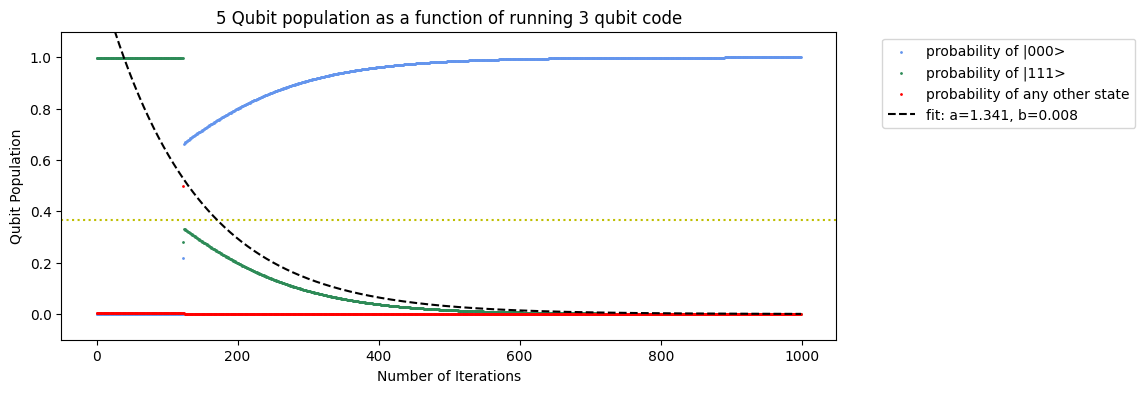

In [17]:
print('The initial state of our system:')
print_state_info(ideal_state, 5)
print('- - -')
print('Physical T1: ', t1*1e6, ' us')
print('Physical T2:', t2*1e6, ' us')
print('Gate time (Tg): ', tg*1e9, 'ns')

plt.figure(figsize=(10,4))
plt.scatter(count, all_pops0, s = 1, c = 'cornflowerblue', label = 'probability of |000>')
plt.scatter(count, all_pops1, s = 1, c ='seagreen', label = 'probability of |111>')
plt.scatter(count, other_probs, s = 1, c ='red', label = 'probability of any other state')

plt.title('5 Qubit population as a function of running 3 qubit code')
plt.xlabel('Number of Iterations')
plt.ylabel('Qubit Population')
plt.axhline(y = 1/np.e, color = 'y', linestyle = 'dotted')

xdata = (count)
ydata = all_pops1

popt, pcov = curve_fit(exp_decay, xdata, ydata)

plt.plot(xdata, exp_decay(xdata, *popt), 'black',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle = 'dashed')
plt.ylim([-0.1, 1.1])
plt.legend()

print('- - - - -')
circuit_runs = 1/popt[1]
print('Calculated Logical T1: ', ((circuit_runs * 29 + 2) * tg)*1e6, 'us')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.show()

## 4. More realistic error implementation <a id='realistic'></a>
#### Now we will implement  Relaxation and Dephasing errors, a depolarizing channel, and State preparation and measurement errors. This is more realistic since in reality our errors will not be discrete and will occur in our gates as well. Thus we will encorporate the gate error porbability and the spam models from <u>05. Error Models</u>.

In [ ]:
# First we define the parameters of our system
zero = np.array([1, 0])
one = np.array([0, 1])

initial_psi = one # initialize our psi

# the parameters of our system
t1 = 200 * 10**-6 # 200 us
t2 = 150 * 10**-6 # 150 us
tg = 20 * 10**-9 # 20 ns

# probability of gate error for each qubit:
p_q0 = 0.0001
p_q1 = 0.0001
p_q2 = 0.00001
p_q3 = 0.0001
p_q4 = 0.000001

# state preparation and measurement errors
spam_prob = 0.00001

# define your error probability for each qubit
qubit_error_probs = np.array([p_q0, p_q1, p_q2, p_q3, p_q4])

In [ ]:
# Apply the CNOT gates to the kronecker product of the current 3 qubit density matrix
rho = initialize_three_qubit_realisitc(
    initial_psi, t1 = t1, t2 = t2, tg = tg, qubit_error_probs=qubit_error_probs, spam=spam_prob)

# collapse density matrix when measuring after we initialized our logical state
collapsed_state = collapse_dm(rho)
print('Measured Initialized logical State: ')
print_state_info(collapsed_state, 5)

# apply the 3 qubit circuit
rho = three_qubit_realistic(
    rho, t1=t1, t2=t2, tg=tg, qubit_error_probs=qubit_error_probs, spam_prob=spam_prob)

# collapse density matrix when measuring after we run the circuit.
collapsed_state = collapse_dm(rho)
print('Final Measured State: ')
print_state_info(collapsed_state, 5)

Now we will perform this circuit many times and plot the population of the 5 qubit system after each implementation

In [ ]:
initial_psi = one

ideal_state = np.dot(CNOT(1, 2, 5), np.dot(CNOT(0, 1, 5), np.kron(
    initial_psi, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))

# the parameters of our system
t1 = 200 * 10**-6 # 200 us
t2 = 150 * 10**-6 # 150 us
tg = 20 * 10**-9 # 20 ns

# probability of gate error for each qubit:
p_q0 = 0.0001
p_q1 = 0.0001
p_q2 = 0.00001
p_q3 = 0.0001
p_q4 = 0.000001

# state preparation and measurement errors
spam_prob = 0.00001

# define your error probability for each qubit
qubit_error_probs = np.array([p_q0, p_q1, p_q2, p_q3, p_q4])

# Initialize our 3 qubit logical state
rho = initialize_three_qubit_realisitc(
    initial_psi, t1 = t1, t2 = t2, tg = tg, qubit_error_probs=qubit_error_probs, spam=spam_prob)

all_pops = np.array([])
count = np.array([])
# Apply the function above 1000 times
for i in range(1000):
    count = np.append(count, i)
    
    rho = three_qubit_realistic(
        rho, t1=t1, t2=t2, tg=tg, qubit_error_probs=qubit_error_probs, spam_prob=spam_prob)
    
    M = np.kron(one_meas, np.kron(one_meas, np.kron(one_meas, np.kron(np.identity(2), np.identity(2)))))
    pop = np.trace(np.dot(M.conj().T, np.dot(M, rho)))
    
    all_pops = np.append(all_pops, pop)

In [ ]:
print('The initial state of our system:')
print_state_info(ideal_state, 5)
print('- - -')
plt.figure(figsize=(10,4))
plt.scatter(count, all_pops, s = 1, label = 'data', c = 'cornflowerblue')
plt.title('5 Qubit population as a function of running 3 qubit code')
plt.xlabel('number of iterations')
plt.ylabel('qubit population')
plt.axhline(y = 1/np.e, color = 'r', linestyle = 'dashed', label = '1/e')
# plt.axvline(x = 58, color = 'g', linestyle = '-')

xdata = (count)
ydata = all_pops

popt, pcov = curve_fit(exp_decay, xdata, ydata)

plt.plot(xdata, exp_decay(xdata, *popt), 'black',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.ylim([0, 1])
plt.legend()

print('Physical T1: ', t1, 'sec | Physical T2: ', t2, 'sec | Gate time (Tg): ', tg, 'sec')
print('Depolarizing error by probability at each qubit: ', qubit_error_probs)

print('- - - - -')
circuit_runs = 1/popt[1]
print('Logical T1: ', ((circuit_runs * 29 + 2) * tg)*1e6, 'us')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()



## 5. Modelling Circuit logical state failure <a id='failure'></a>

We can also test to see if the state remains the same after many iterations of the code.

In [ ]:
initial_psi = np.array([0.8, 0.6]) # initialize our psi

ideal_state = np.dot(CNOT(1, 2, 5), np.dot(CNOT(0, 1, 5), np.kron(
    initial_psi, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))

# the parameters of our system
t1 = 200 * 10**-6 # 200 us
t2 = 150 * 10**-6 # 150 us
tg = 20 * 10**-9 # 20 ns

p_q0 = p_q1 = p_q2 = p_q3 = p_q4 = 1e-3

# define your error probability for each qubit
qubit_error_probs = np.array([p_q0, p_q1, p_q2, p_q3, p_q4])

# state preparation and measurement errors
spam_prob = 0.00001

# Initialize our 3 qubit logical state
rho = initialize_three_qubit_realisitc(
    initial_psi, t1 = t1, t2 = t2, tg = tg, qubit_error_probs=qubit_error_probs, spam=spam_prob)

all_pops = np.array([])
count = np.array([])
# Apply the circuit for many iterations
iterations = 1000
for i in range(iterations):
    count = np.append(count, i)
    
    rho = three_qubit_realistic(
        rho, t1=t1, t2=t2, tg=tg, qubit_error_probs=qubit_error_probs, spam_prob=spam_prob)
    
    M = np.kron(one_meas, np.kron(one_meas, np.kron(one_meas, np.kron(np.identity(2), np.identity(2)))))
    pop = np.trace(np.dot(M.conj().T, np.dot(M, rho)))
    
    all_pops = np.append(all_pops, pop)

for i in range(len(rho)):
    operator = np.zeros((len(rho), len(rho)))
    operator[i][i] = 1
    if i == 0:
        meas_operators = np.array([operator])
    else:
        meas_operators = np.append(meas_operators, [operator], axis = 0)

# Measure probability of each measurement operator
meas_probs = np.array([])
for i in range(len(meas_operators)):
    prob = np.trace(np.dot(meas_operators[i].conj().T, np.dot(meas_operators[i], rho)))
    meas_probs = np.append(meas_probs, prob)

print('States by probability of measuring them after we run the circuit ',iterations, ' times')
print_state_info(meas_probs, 5)
bits = vector_state_to_bit_state(meas_probs, 5)[0]

In [ ]:
print('The initial state of our system:')
print_state_info(ideal_state, 5)
print('...')
print('Relative amplidute of 00000: ',
      np.sqrt(meas_probs[meas_probs!=0][0]/(meas_probs[meas_probs!=0][0] + meas_probs[meas_probs!=0][7])))
print('Relative amplidute of 11100: ',
      np.sqrt(meas_probs[meas_probs!=0][7]/(meas_probs[meas_probs!=0][0] + meas_probs[meas_probs!=0][7])))
print('- - -')
print('Physical T1: ', t1, ' sec')
print('Physical T2 range:', t2, ' sec')
print('Gate time (Tg): ', tg, 'sec')

print('Depolarizing error by probability at each qubit: ', qubit_error_probs)
# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, meas_probs[meas_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States after '+str(iterations)+' iterations ')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

Now lets plot an average distribution of the number of runs it takes until our state is no longer the same due to depolarization and spam errors

In [19]:
initial_psi = one # initialize our psi

ideal_state = np.dot(CNOT(1, 2, 5), np.dot(CNOT(0, 1, 5), np.kron(
    initial_psi, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))

# the parameters of our system
t1 = 200 * 10**-6 # 200 us
t2 = 150 * 10**-6 # 150 us
tg = 20 * 10**-9 # 20 ns

# define your error probability for each qubit
p_q0 = p_q1 = p_q2 = p_q3 = p_q4 = 1e-6
qubit_error_probs = np.array([p_q0, p_q1, p_q2, p_q3, p_q4])

# state preparation and measurement errors
spam_prob = 1e-6

all_pops = np.array([])
count = np.array([])
overall_count = np.array([])
# Apply the function above 200 times to run the circuit 200 times
iterations = 500
samples = 200

for k in range(samples):
    # Initialize our logical state depending on parameters
    rho = initialize_three_qubit_realisitc(
        initial_psi, t1 = t1, t2 = t2, tg = tg, qubit_error_probs=qubit_error_probs, spam_prob=spam_prob)
    overall_count = np.append(overall_count, k)
    for i in range(iterations):
        rho = three_qubit_realistic(
            rho, t1=t1, t2=t2, tg=tg, qubit_error_probs=qubit_error_probs, spam_prob=spam_prob)

        if vector_state_to_bit_state(collapse_dm(rho), 5)[0][0] != vector_state_to_bit_state(
            ideal_state, 5)[0][0]:
            if len(vector_state_to_bit_state(ideal_state, 5)[0]) > 1:
                if vector_state_to_bit_state(collapse_dm(rho), 5)[0][0] != vector_state_to_bit_state(
                    ideal_state, 5)[0][1]:
                    break
            else:
                break
        
        M = np.kron(one_meas, np.kron(one_meas, np.kron(one_meas, np.kron(np.identity(2), np.identity(2)))))
        pop = np.trace(np.dot(M.conj().T, np.dot(M, rho)))
    
        all_pops = np.append(all_pops, pop)  
        
    count = np.append(count, i)

The initial state of our system:
11100 :  1.0
- - -
Physical T1:  0.00019999999999999998  sec
Physical T2 range: 0.00015  sec
Gate time (Tg):  2e-08 sec
Depolarizing error by probability at each qubit:  [1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
SPAM error probability:  1e-06
- - -
Total number of samples:  200
Number of iterations per sample:  500
- - -
Characteristic number of runs until failure:  92.11247030394449
Characteristic time until failure:  5.3465232776287805e-05 sec


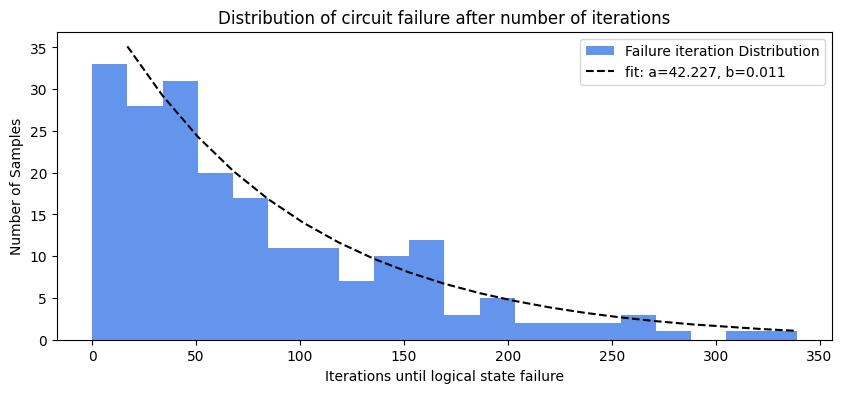

In [28]:
print('The initial state of our system:')
print_state_info(ideal_state, 5)
print('- - -')
print('Physical T1: ', t1, ' sec')
print('Physical T2 range:', t2, ' sec')
print('Gate time (Tg): ', tg, 'sec')

print('Depolarizing error by probability at each qubit: ', qubit_error_probs)
print('SPAM error probability: ', spam_prob)


print('- - -')
print('Total number of samples: ', samples)
print('Number of iterations per sample: ', iterations)

# Plotting the error state probabilities
plt.figure(figsize=(10,4))# passing the histogram function
bins = int(samples/10)
while True:
    n, bins, patches = plt.hist(count, bins = bins, label = 'Failure iteration Distribution', color = 'cornflowerblue')
    plt.title('Distribution of circuit failure after number of iterations')
    plt.xlabel('Iterations until logical state failure') 
    plt.ylabel('Number of Samples') 

    # - - - Fitting a curve to our plot - - - #

    xdata = (bins[bins!=0])[n!=0]
    ydata = n[n!=0]

    popt, pcov = curve_fit(exp_decay, xdata, ydata)
    if 0<popt[1]<1:
        plt.plot(xdata, exp_decay(xdata, *popt), 'black',
                 label='fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle = 'dashed')
        print('- - -')

        circuit_runs = 1/popt[1]
        print('Characteristic number of runs until failure: ', circuit_runs)

        char_time = ((circuit_runs * 29 + 2) * tg)
        print('Characteristic time until failure: ', char_time, 'sec')
        break
    bins +=1
# Add a Legend
plt.legend()
plt.show()